In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr

/home/remedios/kaisr/kaisr


In [3]:
import nibabel as nib
import numpy as np
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import torch

from utils.plot import *
from tqdm import tqdm

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
set_display_mode(mode='dark')

In [6]:
DTYPE = np.float32

In [7]:
fpath = Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")

In [8]:
vol = nib.load(fpath).get_fdata(dtype=DTYPE)

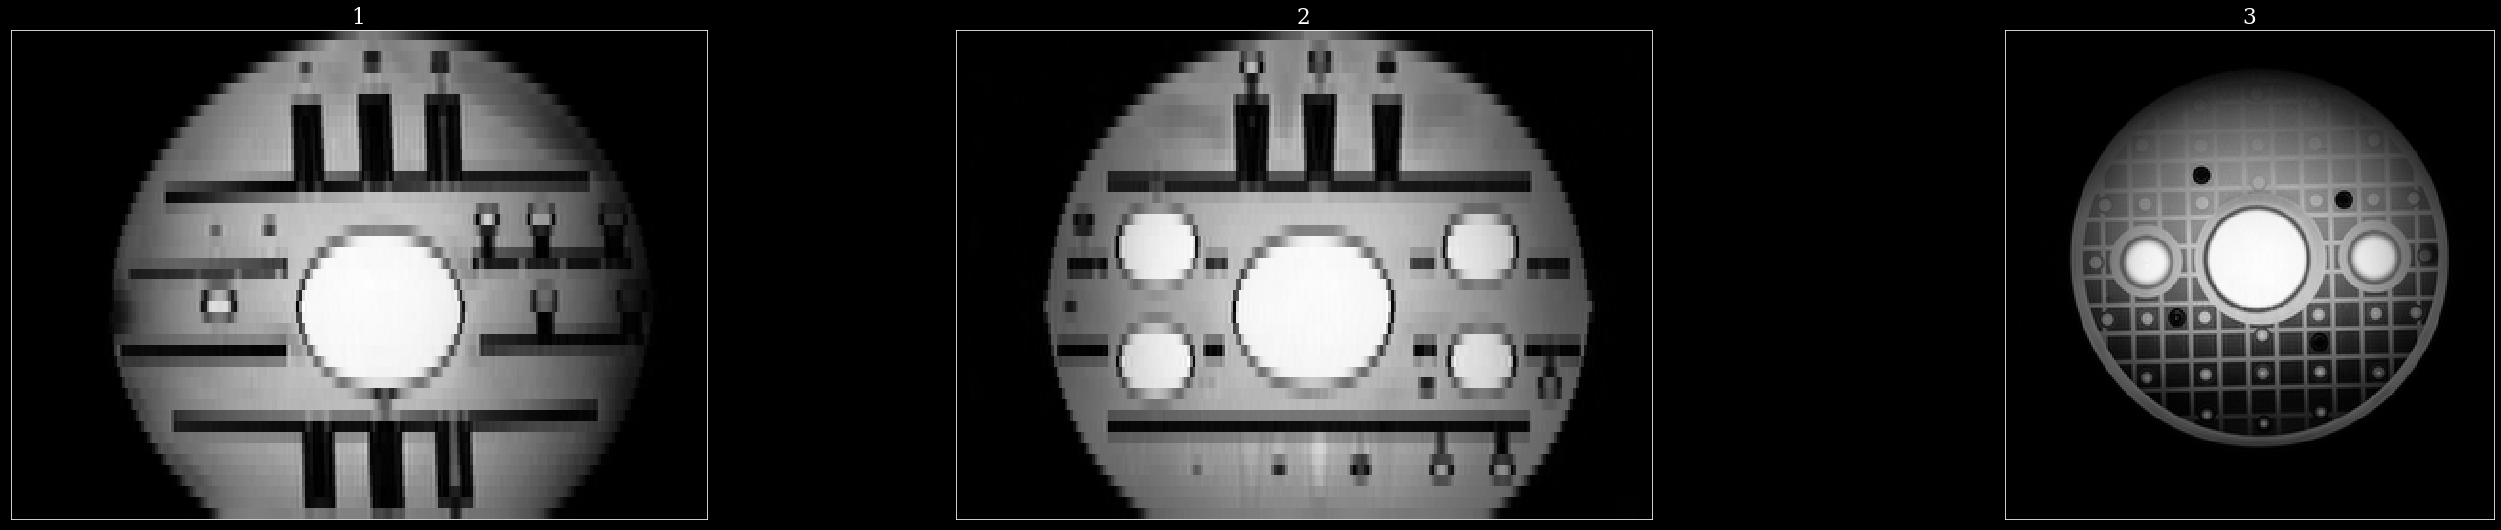

In [9]:
center_vol_plot(vol, target_shape=(256, 256, 180))

In [10]:
from utils.train_loader_slices import TrainSet
from torch.utils.data import DataLoader

In [11]:
batch_size = vol.shape[-1]
n_iters = 5000

In [12]:
ds = TrainSet(
    img_fpath=fpath,
    n_iters=n_iters,
    slice_axis=2,
)

data_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True, 
    pin_memory=True,
    num_workers=4,
)

In [13]:
device = torch.device(f'cuda:0')

In [14]:
real_imgs = ds.get_all_slices_as_tensor().to(device)

In [15]:
from models.fastgan import Generator, Discriminator

In [16]:
z_dim = 128

In [17]:
G = Generator(ngf=32, nz=z_dim, nc=1, im_size=256).to(device)
D = Discriminator(ndf=32, nc=1, im_size=256).to(device)

In [18]:
lr = 1e-4
opt_G = torch.optim.AdamW(G.parameters(), lr=lr)
opt_D = torch.optim.AdamW(D.parameters(), lr=lr)

opt_G.zero_grad()
opt_G.step()

opt_D.zero_grad()
opt_D.step()

# Loss function
adversarial_loss = torch.nn.BCELoss().to(device)

In [19]:
N_STEPS = n_iters

scheduler_G = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt_G,
    max_lr=lr,
    total_steps=N_STEPS+1,  # handles the `step()` below
    cycle_momentum=True,
)

scheduler_D = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt_D,
    max_lr=lr,
    total_steps=N_STEPS+1,  # handles the `step()` below
    cycle_momentum=True,
)

In [20]:
discrim_freq = 1

In [21]:
with tqdm(total=n_iters) as pbar:    
    pbar_dict = {
        'G_disrcrim_loss': np.finfo(np.float32).max,
        'D_disrcrim_loss': np.finfo(np.float32).max,
    }
    # Adversarial ground truths
    valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
    fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

    for cur_step in range(n_iters):
#         real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------
        # freeze the discriminator
        for p in D.parameters():
            p.requires_grad = False
        opt_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn((real_imgs.shape[0], z_dim), device=device)

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(D(gen_imgs, label='real'), valid[:imgs.shape[0]])
        g_loss.backward()
        opt_G.step()
        scheduler_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        if cur_step % discrim_freq == 0:
            # unfreeze the discriminator
            for p in D.parameters():
                p.requires_grad = True

            opt_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            if np.random.rand() < 0.5:
                d_loss = adversarial_loss(D(real_imgs, label='real'), valid[:imgs.shape[0]])
            else:
                d_loss = adversarial_loss(D(gen_imgs.detach(), label='fake'), fake[:imgs.shape[0]])

            d_loss.backward()
            opt_D.step()
            scheduler_D.step()

        pbar_dict['G_disrcrim_loss'] = g_loss.item()
        pbar_dict['D_disrcrim_loss'] = d_loss.item()

        pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
        pbar.update(batch_size)

  0%|                                                                                                                              | 0/5000 [00:00<?, ?it/s]


AssertionError: 

In [ ]:
# visualize 16 samples
z = torch.randn((batch_size, z_dim), device=device)
samples = G(z).detach().cpu().numpy()[:16]

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, ax in enumerate(axs.flat):
    ax.imshow(samples.squeeze()[i])
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
plt.hist(samples[0].flatten(), bins=256)
plt.yscale("log")
plt.show()

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

real_batch = [ds.__getitem__(i) for i in range(16)]
for i, ax in enumerate(axs.flat):
    ax.imshow(real_batch[i].squeeze())
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
plt.hist(real_batch[5].flatten(), bins=256)
plt.yscale("log")
plt.show()

In [ ]:
# GAN results are pushing too far positive/negative. Need to regularize somehow...

In [ ]:
# with tqdm(total=n_patches) as pbar:
#     pbar_dict = {
#         'G_MSE_loss': np.finfo(np.float32).max,
#         'G_disrcrim_loss': np.finfo(np.float32).max,
#         'D_disrcrim_loss': np.finfo(np.float32).max,
#     }

#     for cur_step, ys in enumerate(data_loader):
#         ys = ys.to(device)
#         # Generate batch of latent vectors
#         z = torch.randn((batch_size, z_dim), device=device)

#         # Generate fake image batch with G
#         # and select the correct level in the output
#         fakes = G(z)
        
#         # choose if this batch will be all-real or all-fake
#         cur_batch_real = np.random.rand() < 0.5
            
#         if cur_step % discrim_freq == 0:
#             ############################
#             # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#             # This happens for each level
#             ###########################
#             # unfreeze the discriminator
#             for p in D.parameters():
#                 p.requires_grad = True

#             ## Train with all-real batch
#             opt_D.zero_grad()
#             if cur_batch_real:
#                 labels = torch.ones_like(ys, requires_grad=True).to(device)
#                 preds = D(ys)
#             else:
#                 labels = torch.zeros_like(ys, requires_grad=True).to(device)
#                 preds = D(fakes.detach())
                
#             # Calculate loss 
#             errD = discrim_loss(preds, labels) * lambda_adv
            
#             errD.backward()
#             # Update D
#             opt_D.step()
# #             scheduler_D.step()
        
#         ############################
#         # (2) Update G network: maximize log(D(G(z)))
#         ###########################
#         opt_G.zero_grad()
#         # freeze the discriminator
#         for p in D.parameters():
#             p.requires_grad = False

#         ys_hat = G(z)
#         # Calculate reconstruction loss on G
#         errGMSE = recon_loss(ys_hat, ys) * lambda_mse
#         errGMSE.backward()
        
#         # Calculate discrimination loss through each D
#         # fake labels are real for generator cost
#         labels = torch.ones_like(ys, requires_grad=True).to(device)
#         preds = D(ys_hat.detach())
#         errG = discrim_loss(preds, labels) * lambda_adv 

#         # Calculate gradients for G
#         errG.backward()
#         # Update G
#         opt_G.step()
# #         scheduler_G.step()
        
#         # Remove the lambda scaling so we can compare across experiments
#         disp_errGMSE = errGMSE.detach().cpu().numpy().item() / lambda_mse
#         disp_errG = errG.detach().cpu().numpy().item() / lambda_adv
#         disp_errD = errD.detach().cpu().numpy().item() / lambda_adv
        
#         pbar_dict['G_MSE_loss'] = disp_errGMSE
#         pbar_dict['G_disrcrim_loss'] = disp_errG
#         pbar_dict['D_disrcrim_loss'] = disp_errD
        
# #         writer.add_scalar('G_MSE_loss', disp_errGMSE, cur_step)
# #         writer.add_scalar('adv/G', disp_errG, cur_step)
# #         writer.add_scalar('adv/D', disp_errD, cur_step)
        

        
#         pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
#         pbar.update(batch_size)